In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [2]:
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [3]:
# Xavier初始化权重

def xavier(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

class MyNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.f1=nn.Linear(input_dim,input_dim*8)
        self.drop1=nn.Dropout(p=0.2)
        self.s1=nn.ReLU()
        
        self.f2=nn.Linear(input_dim*8,input_dim*8)
        self.drop2=nn.Dropout(p=0.35)
        self.s2=nn.ReLU()
        
        self.f3=nn.Linear(input_dim*8,input_dim*8)
        self.drop3=nn.Dropout(p=0.5)
        self.s3=nn.ReLU()    
        
        self.f4=nn.Linear(input_dim*8,input_dim*8)
        self.drop4=nn.Dropout(p=0.35)
        self.s4=nn.ReLU()
                    
        self.f5=nn.Linear(input_dim*8,2)   
        self.s5=nn.Softmax(dim=1)
        
    
    def forward(self,x):
        x=self.s1(self.drop1(self.f1(x)))
        x=self.s2(self.drop2(self.f2(x)))
        x=self.s3(self.drop3(self.f3(x)))
        x=self.s4(self.drop4(self.f4(x)))
        return self.s5(self.f5(x))
        
#     预测
    def predict(self,x):
        with torch.no_grad():
            x=self.s1(self.f1(x))
            x=self.s2(self.f2(x))
            x=self.s3(self.f3(x))
            x=self.s4(self.f4(x))
            p=self.s5(self.f5(x))
            return (p[:,0]<p[:,1])
            
    def compute(self,x):
        with torch.no_grad():
            x=self.s1(self.f1(x))
            x=self.s2(self.f2(x))
            x=self.s3(self.f3(x))
            x=self.s4(self.f4(x))
            p=self.s5(self.f5(x))
            return p    
#     准确率 
    def acc(self,x,y):
        with torch.no_grad():
            return float(((self.predict(x)==y).sum()/len(y)))

In [4]:
X_test_all=torch.FloatTensor(test.drop('label',axis=1).values).cuda('cuda:0')
Y_test_all=          torch.LongTensor(test['label'].values).cuda('cuda:0')
Y_true=Y_test_all.to(torch.device('cpu'))

In [5]:
n_block=25
nets=[]
for i in range(1,n_block*2+1,2):
    path='/content/drive/MyDrive/Colab Notebooks/RSP25/Net_'+str(i)+'+'+str(i+1)+'.params'
    net=MyNet(X_test_all.shape[1]).cuda("cuda:0")
    net.load_state_dict(torch.load(path))
    nets.append(net)

In [6]:
# avg_acc=0
# for i in range(n_block):
#   cur_acc=nets[i].acc(X_test_all,Y_test_all)
#   print('Acc of Net '+str(i+1),': ',cur_acc)
#   avg_acc+=cur_acc
# avg_acc/=n_block


In [7]:
# print('Average acc of 25 blocks: ',avg_acc)

**avg_acc=0.7434457349777222**

In [8]:
# def Voting(ss_net,n_net,x,y):
#     y_preds=[]
#     for i in range(n_net):
#         y_preds.append(ss_net[i].predict(X_test).to(torch.device('cpu')).numpy())
#     y_preds=np.array(y_preds).sum(0)>n_net//2
#     return y_preds


In [9]:
# test_iter=DataLoader(
#     TensorDataset(X_test_all,Y_test_all),
#     batch_size=2**18,
#     shuffle=True
# )

In [16]:
def Bagging(nets,n_block):
  res=0
  for i in range(n_block):
    with torch.no_grad():
      res+=(nets[i].compute(X_test_all)).to(torch.device('cpu'))
  return (res[:,0]<res[:,1])

In [20]:
accs=[]
for i in range(1,n_block+1):
  tmp=float((Bagging(nets,i)==Y_true).sum()/len(Y_true))
  print(str(i)+': ',tmp)
  accs.append(tmp)

1:  0.7409651279449463
2:  0.7493612170219421
3:  0.7519512176513672
4:  0.7540375590324402
5:  0.7549072504043579
6:  0.7556509375572205
7:  0.7560645341873169
8:  0.7564557790756226
9:  0.7567800283432007
10:  0.7570178508758545
11:  0.7572027444839478
12:  0.7574403285980225
13:  0.757530927658081
14:  0.7577248215675354
15:  0.7579084634780884
16:  0.7579060792922974
17:  0.7579911947250366
18:  0.7580924034118652
19:  0.7581145167350769
20:  0.758173942565918
21:  0.7581893801689148
22:  0.7582100033760071
23:  0.7582736611366272
24:  0.7582966685295105
25:  0.7583533525466919


Text(0.5, 1.0, 'Single Classifier vs 25Muti-Classifiers')

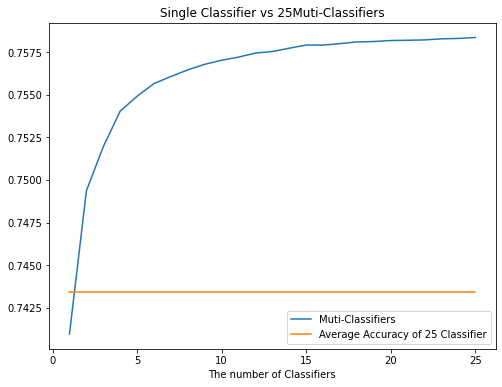

In [30]:
%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(np.arange(n_block)+1,accs,label='Muti-Classifiers')
plt.plot([1,n_block],[0.7434457349777222,0.7434457349777222],label='Average Accuracy of 25 Classifier')
plt.legend()
plt.xlabel('The number of Classifiers')
plt.title('Single Classifier vs ' +str(n_block) +'Muti-Classifiers')

### 没有经过任何预处理的25RSP渐进学习
可以看到正确率一直在上升